# Анализ выбора портфеля по коэффициенту Шарпа жадным алгоритмом

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Считываем данные

In [5]:
data = pd.read_csv("Россия 37 Акций 2016-01.07.2019.txt")
data = np.array(data)
periods_in_data = data.shape[0]
print(periods_in_data)
data = np.delete(data, 0, axis = 1)
#data = np.delete(data, 0, axis = 1)  # Удалять дополительно второй столбец только в часовых котировках

881


In [6]:
print(data)

[[-1.521804   -1.52155153 -3.20955955 ... -2.70986745  0.47138047
  11.16636528]
 [ 3.02138343  1.12824001  0.89786756 ...  3.70874962  2.37935657
  11.26474176]
 [-0.08403361 -0.31696625 -2.06289817 ... -1.16771274 -0.57283142
   3.80116959]
 ...
 [ 0.40123169  0.16287467 -0.03740804 ...  0.60020007  1.16510655
   1.03524229]
 [-1.39405204 -0.49682335 -0.81081081 ... -0.49718263 -0.33467861
  -1.26444299]
 [ 1.38548539  1.28785003  1.85705303 ...  0.41638907 -0.68148148
   3.86398764]]


In [7]:
start = datetime.now()

stocks_to_portf_min = 5
stocks_to_portf_max = 6
stocks_to_portf_step = 1

sharp_period_min = 60
sharp_period_max = 200
sharp_period_step = 20

hold_period_min = 20       # Важна кратность диапазона end-start по hold(step)
hold_period_max = 260
hold_period_step = 20

sharp_period = 125
start_of_test_period = sharp_period_max
end_of_test_period = (periods_in_data // hold_period_max - 1) * hold_period_max

mean_annual_profit_overal = []
P_L_overal = []
random_income_overal = []
random_portf_list = []
# Рассматриваем разное количество акций в портфеле по Кэф Шарпа
for stocks_to_portf in range(stocks_to_portf_min, stocks_to_portf_max, stocks_to_portf_step):
    # Рассматриваем разный период рассчета Кэф Шарпа.
    for sharp_period in range(sharp_period_min,sharp_period_max,sharp_period_step):
        #Смотрим также результаты стратегии Купи и держи в те же периоды.
        P_L_by_hold = []
        mean_annual_profit_by_hold = []
        random_income_hold = []
        for hold in range(hold_period_min,hold_period_max,hold_period_step):
            start_of_test_period = sharp_period_max # Должен быть больше чем sharp_period
            columns_count = data.shape[1] # число акций
            stocks_to_portf_list = []
            overal_results = []
            random_portf_list = []
            
            for i in range(start_of_test_period,end_of_test_period,hold): # Пересчитываем через период hold коэфф Шарпа
                stocks_to_portf_list = []          
                counter = 1
                random_portf = np.mean(np.array(data[i-sharp_period:i,:]))
                random_array = np.array(data[i-sharp_period:i,:])
                random_portf_list.append(random_portf)
                for k in range(0, stocks_to_portf):
                    sharp_ratio_list = []
                    if counter == 1:                             # Выбираем первую акцию в портфель
                        for j in range(0, columns_count):
                            share_prices = np.array(data[i-sharp_period:i,j], dtype=float)
                            income = np.sum(share_prices)
                            std = np.std(share_prices)
                            if std > 0 and income > 0:
                                sharp_ratio = income/std
                            else:
                                sharp_ratio = 0
                            sharp_ratio_list.append(sharp_ratio)
                        
                        max_sharp_ratio = max(sharp_ratio_list)
                        indx_max_sharp_ratio = np.argmax(sharp_ratio_list)
                        comulative_income = np.array(data[i-sharp_period:i,indx_max_sharp_ratio], dtype=float)   # Инициализируем доход портфеля
                        stocks_to_portf_list.append(indx_max_sharp_ratio)
                        counter = counter + 1
                    else:
                        for j in range(0, columns_count):
                            if j in stocks_to_portf_list:    # Чтобы не включать акцию повторно
                                sharp_ratio_list.append(0)
                            else:
                                share_prices = np.array(data[i-sharp_period:i,j], dtype=float)
                                sub_sumpl_comulative_income = comulative_income + share_prices 
                                income = np.sum(sub_sumpl_comulative_income)
                                std = np.std(sub_sumpl_comulative_income)
                                if std > 0 and income > 0:
                                    sharp_ratio = income/std
                                else:
                                    sharp_ratio = 0
                                sharp_ratio_list.append(sharp_ratio)
                        
                        max_sharp_ratio = max(sharp_ratio_list)
                        indx_max_sharp_ratio = np.argmax(sharp_ratio_list)
                        comulative_income = comulative_income + np.array(data[i-sharp_period:i,indx_max_sharp_ratio], dtype=float)
                        stocks_to_portf_list.append(indx_max_sharp_ratio)
                        counter = counter + 1
                
                stocks_to_portf_list = np.array(stocks_to_portf_list)
                #print(stocks_to_portf_list)
                for j in range(0,stocks_to_portf):
                    if j == 0:
                        stock_ind = stocks_to_portf_list[j]
                        results = np.array(data[i:i+hold,stock_ind])#, dtype=float)
                    else:
                        stock_ind = stocks_to_portf_list[j]
                        results = results + np.array(data[i:i+hold,stock_ind])#, dtype=float)
                results = np.array(results)        
                overal_results.append(results)
            
            overal_results = np.array(overal_results)    
            print(overal_results.shape)
            time = datetime.now()
            inter_time = time - start
            print(inter_time)
            # Анализируем результаты
            strings = overal_results.shape[0]
            rows  = overal_results.shape[1]
            
            mean_profit_list = []
            P_L_list = []
            
            for i in range(0, overal_results.shape[0]):
                profit = 0
                loss = 0
                for j in range(0, overal_results.shape[1]):
                    if overal_results[i][j] >= 0:
                        profit = profit + overal_results[i][j]
                    else:
                        loss = loss + overal_results[i][j]
                        
                mean_profit = (profit + loss)/stocks_to_portf
                if loss < 0:
                    P_L = -profit / loss
                else:
                    P_L = 5
                mean_profit_list.append(mean_profit)
                P_L_list.append(P_L)
            
            mean_profit_list = np.array(mean_profit_list)
            P_L_list = np.array(P_L_list)
            random_portf_list = np.array(random_portf_list)
            
            mean_annual_profit = mean_profit_list.mean()*(250 / hold)     # Менять когда час 2250 или День 250 
            P_L = P_L_list.mean()
            random_income = random_portf_list.mean() * 250              # Менять когда час 2250 или День 250
            
            mean_annual_profit_by_hold.append(mean_annual_profit)
            P_L_by_hold.append(P_L)
            random_income_hold.append(random_income)
            
            #print('mean_annual_profit_by_hold:', mean_annual_profit_by_hold)
            #print('P_L_list.mean:', P_L)
            #print('random_portf_mean_profit:', random_income)
            
        
        mean_annual_profit_by_hold = np.array(mean_annual_profit_by_hold)
        P_L_by_hold = np.array(P_L_by_hold)
        random_income_hold = np.array(random_income_hold)
        
        mean_annual_profit_overal.append(mean_annual_profit_by_hold)
        P_L_overal.append(P_L_by_hold)
        random_income_overal.append(random_income_hold)
            
#mean_annual_profit_overal = np.array(mean_annual_profit_overal)       
#P_L_overal = np.array(P_L_overal)
#random_income_overal = np.array(random_income_overal)  

hold_periods = range(hold_period_min, hold_period_max, hold_period_step)
sharp_periods = range(sharp_period_min, sharp_period_max, sharp_period_step)

mean_annual_profit_overal = pd.DataFrame(mean_annual_profit_overal)
P_L_overal = pd.DataFrame(P_L_overal)
random_income_overal = pd.DataFrame(random_income_overal)
                                        
mean_annual_profit_overal.columns = hold_periods
P_L_overal.columns = hold_periods
random_income_overal.columns = hold_periods

#mean_annual_profit_overal.insert(0, 'sharp_periods', sharp_periods)
#P_L_overal.insert(0, 'sharp_periods', sharp_periods)
#random_income_overal.insert(0, 'sharp_periods', sharp_periods)

#print(mean_annual_profit_overal)
#print(P_L_overal)
#print(random_income_overal)

finish = datetime.now()
time_consumed = finish - start
print('start:', start)
print('finish:', finish)
print('time_consumed:', time_consumed)

#random_max_list = []
#random_min_list = []
#for i in range(0,random_array.shape[0]):
#    random_max_list.append(np.max(random_array[i,:]))
#    random_min_list.append(np.min(random_array[i,:]))
#
#print('random_max_list:', random_max_list)
#print('random_min_list:', random_min_list)

(16, 20)
0:00:00.187000
(8, 40)
0:00:00.281997
(6, 60)
0:00:00.352996
(4, 80)
0:00:00.402999
(4, 100)
0:00:00.462273
(3, 120)
0:00:00.500270
(3, 140)
0:00:00.536272
(2, 160)
0:00:00.564270
(2, 180)
0:00:00.590270
(2, 200)
0:00:00.617270
(2, 220)
0:00:00.647275
(2, 240)
0:00:00.673271
(16, 20)
0:00:00.877275
(8, 40)
0:00:00.981983
(6, 60)
0:00:01.054983
(4, 80)
0:00:01.097982
(4, 100)
0:00:01.143983
(3, 120)
0:00:01.179985
(3, 140)
0:00:01.219986
(2, 160)
0:00:01.244984
(2, 180)
0:00:01.268983
(2, 200)
0:00:01.296987
(2, 220)
0:00:01.322984
(2, 240)
0:00:01.349983
(16, 20)
0:00:01.531584
(8, 40)
0:00:01.618581
(6, 60)
0:00:01.686583
(4, 80)
0:00:01.733581
(4, 100)
0:00:01.783581
(3, 120)
0:00:01.818584
(3, 140)
0:00:01.853584
(2, 160)
0:00:01.875581
(2, 180)
0:00:01.900584
(2, 200)
0:00:01.924580
(2, 220)
0:00:01.952118
(2, 240)
0:00:01.978268
(16, 20)
0:00:02.172266
(8, 40)
0:00:02.262265
(6, 60)
0:00:02.335265
(4, 80)
0:00:02.388268
(4, 100)
0:00:02.435265
(3, 120)
0:00:02.471874
(3, 

In [8]:
print(mean_annual_profit_overal.mean().mean())

23.232745828380175


[Text(0.5, 1.0, 'Средний годовой доход стратегии')]

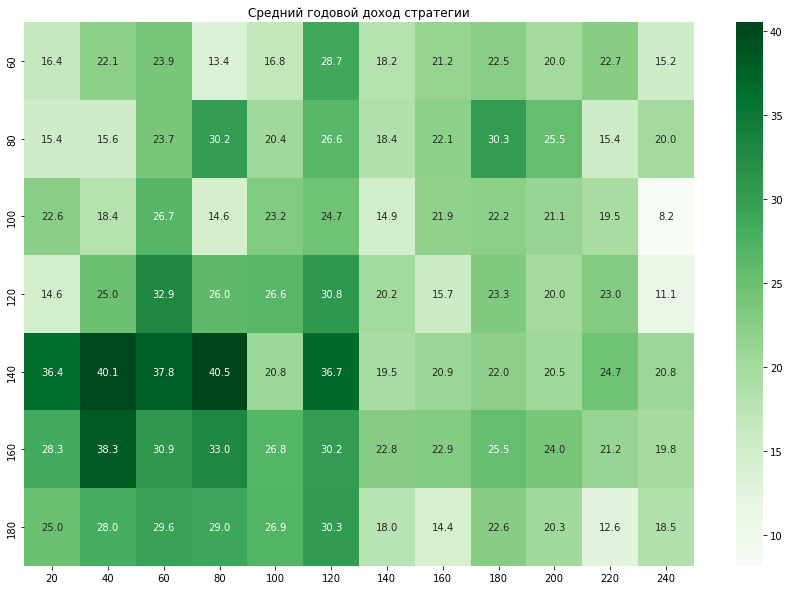

In [9]:
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(mean_annual_profit_overal, annot=True, fmt=".1f", xticklabels = True,
            yticklabels = sharp_periods, cmap="Greens").set(title='Средний годовой доход стратегии')

[Text(0.5, 1.0, 'Профит фактор (отношение Прибыль/Убыток) стратегии')]

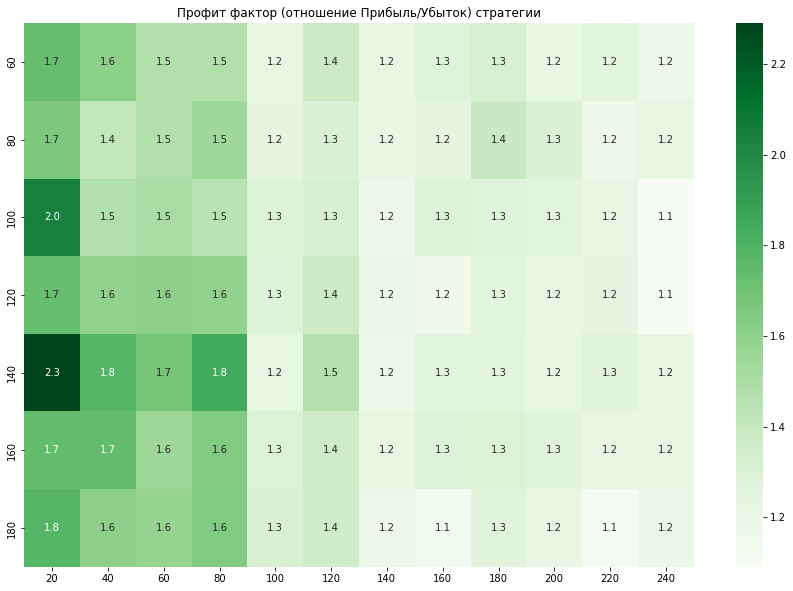

In [10]:
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(P_L_overal, annot=True, fmt=".1f", xticklabels = True,
            yticklabels = sharp_periods, cmap="Greens").set(title='Профит фактор (отношение Прибыль/Убыток) стратегии')

[Text(0.5, 1.0, 'Средний годовой доход средний по рынку')]

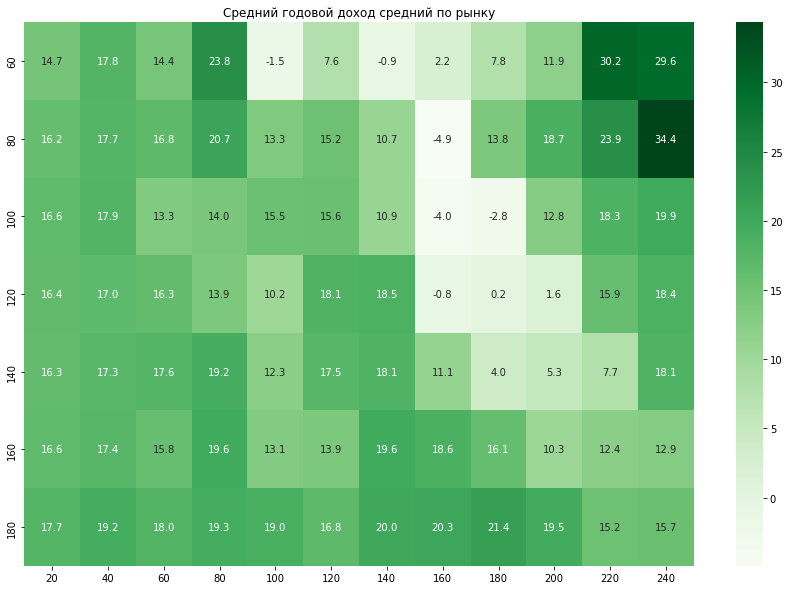

In [11]:
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(random_income_overal, annot=True, fmt=".1f", xticklabels = True,
            yticklabels = sharp_periods, cmap="Greens").set(title='Средний годовой доход средний по рынку')

In [34]:
print(random_income_overal.mean().mean())

16.300323624512
